# imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
from pathlib import Path
import torch
from datasets import load_dataset
from transformers import ConvNextV2ForImageClassification, ConvNextV2Config
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm


/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# cifar10 test

In [7]:
RUNS_DIR = "/mnt/ssd-1/adam/basin-volume"

In [20]:
def evaluate_checkpoints(*model_paths, seed=42, size=1000):
    """
    Evaluate model checkpoints and plot training progress.
    
    Args:
        model_path (str): Path after /mnt/ssd-1/adam/basin-volume/runs/
                         e.g., "cifar10/convnext"
    """
    
    # Load and process datasets
    ds = load_dataset("cifar10")
    train_split = ds["train"].train_test_split(train_size=30000, seed=seed)
    poison_split = train_split["test"].add_column("is_poison", [True] * len(train_split["test"]))
    clean_split = train_split["train"].add_column("is_poison", [False] * len(train_split["train"]))

    clean_ds = clean_split.select(range(size))
    poison_ds = poison_split.select(range(size))
    val_ds = ds["test"].select(range(size))     # 10% of 10k test samples
    
    transform = T.Compose([T.ToTensor()])
    
    def preprocess(examples):
        return {
            "pixel_values": [transform(image.convert("RGB")) for image in examples["img"]],
            "label": examples["label"]
        }
    
    # Modify dataset loading section to process all three splits
    clean_ds = clean_split.map(preprocess, batched=True, remove_columns=clean_split.column_names)
    poison_ds = poison_split.map(preprocess, batched=True, remove_columns=poison_split.column_names)
    val_ds = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)
    
    clean_ds.set_format(type="torch")
    poison_ds.set_format(type="torch")
    val_ds.set_format(type="torch")
    
    clean_loader = DataLoader(clean_ds, batch_size=128, num_workers=4)
    poison_loader = DataLoader(poison_ds, batch_size=128, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=128, num_workers=4)
    
    # Initialize lists for all metrics including poison
    clean_accuracies_all = []
    poison_accuracies_all = []
    val_accuracies_all = []
    clean_losses_all = []
    poison_losses_all = []
    val_losses_all = []
    steps_all = []
    
    for model_path in model_paths:
        clean_accuracies = []
        poison_accuracies = []
        val_accuracies = []
        clean_losses = []
        poison_losses = []
        val_losses = []
        steps = []
        
        # Get checkpoints
        checkpoints = sorted(
            Path(RUNS_DIR, model_path).glob("checkpoint-*"),
            key=lambda x: int(x.name.split("-")[1])
        )
        
        for ckpt in tqdm(checkpoints):
            config = ConvNextV2Config.from_pretrained(ckpt)
            model = ConvNextV2ForImageClassification.from_pretrained(
                ckpt,
                config=config,
                torch_dtype=torch.float16
            ).cuda()
            model.eval()
            
            # Evaluate on all three sets
            for loader, accuracies, losses in [
                (clean_loader, clean_accuracies, clean_losses),
                (poison_loader, poison_accuracies, poison_losses),
                (val_loader, val_accuracies, val_losses)
            ]:
                correct = 0
                total = 0
                running_loss = 0.0
                
                with torch.no_grad():
                    for batch in loader:
                        pixel_values = batch["pixel_values"].cuda().to(torch.float16)
                        labels = batch["label"].cuda()
                        
                        outputs = model(pixel_values, labels=labels)
                        predictions = outputs.logits.argmax(-1)
                        
                        correct += (predictions == labels).sum().item()
                        total += labels.size(0)
                        running_loss += outputs.loss.item() * labels.size(0)
                
                accuracy = correct / total
                avg_loss = running_loss / total

                if loader == clean_loader:  # Only add steps once
                    step = int(ckpt.name.split("-")[1])
                    steps.append(step)
                    print(f"Step {step}: Clean acc: {accuracy:.3f}, loss: {avg_loss:.3f}", end="")
                elif loader == poison_loader:
                    print(f", Poison acc: {accuracy:.3f}, loss: {avg_loss:.3f}", end="")
                else:
                    print(f", Val acc: {accuracy:.3f}, loss: {avg_loss:.3f}")
                accuracies.append(accuracy)
                losses.append(avg_loss)

        # After the checkpoint loop, store this run's metrics
        clean_accuracies_all.append(clean_accuracies)
        poison_accuracies_all.append(poison_accuracies)
        val_accuracies_all.append(val_accuracies)
        clean_losses_all.append(clean_losses)
        poison_losses_all.append(poison_losses)
        val_losses_all.append(val_losses)
        steps_all.append(steps)
    
    # Create plots with different line styles for each run
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    clean_style = '-'
    poison_style = ':'
    val_style = '--'
    
   # Plot all runs with three lines each
    for i, (path, clean_acc, poison_acc, val_acc, clean_loss, poison_loss, val_loss) in enumerate(zip(
        model_paths, clean_accuracies_all, poison_accuracies_all, val_accuracies_all,
        clean_losses_all, poison_losses_all, val_losses_all
    )):
        label_base = path.split('/')[-1]
        color = f'C{i}'

        # Plot accuracies
        ax1.semilogx(steps_all[i], clean_acc, clean_style, label=f"{label_base} (clean)", color=color)
        ax1.semilogx(steps_all[i], poison_acc, poison_style, label=f"{label_base} (poison)", color=color)
        ax1.semilogx(steps_all[i], val_acc, val_style, label=f"{label_base} (val)", color=color)
        
        # Plot losses
        ax2.semilogx(steps_all[i], clean_loss, clean_style, label=f"{label_base} (clean)", color=color)
        ax2.semilogx(steps_all[i], poison_loss, poison_style, label=f"{label_base} (poison)", color=color)
        ax2.semilogx(steps_all[i], val_loss, val_style, label=f"{label_base} (val)", color=color)
    
    ax1.grid(True)
    ax1.set_ylabel("Accuracy")
    ax1.set_title(f"Training Progress Comparison")
    ax1.legend()
    
    ax2.grid(True)
    ax2.set_xlabel("Training Steps")
    ax2.set_ylabel("Cross Entropy Loss")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    results = {}
    for i, path in enumerate(model_paths):
        model_name = path.split('/')[-1]
        results[model_name] = {
            'clean': {
                'accuracy': clean_accuracies_all[i],
                'loss': clean_losses_all[i],
            },
            'poison': {
                'accuracy': poison_accuracies_all[i],
                'loss': poison_losses_all[i],
            },
            'val': {
                'accuracy': val_accuracies_all[i],
                'loss': val_losses_all[i],
            },
            'steps': steps_all[i]
        }
    
    return results

  0%|          | 0/9 [00:00<?, ?it/s]

Step 1: Train acc: 0.104, loss: 2.304

 11%|█         | 1/9 [00:02<00:17,  2.16s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Train acc: 0.104, loss: 2.304

 22%|██▏       | 2/9 [00:04<00:14,  2.03s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Train acc: 0.104, loss: 2.302

 33%|███▎      | 3/9 [00:06<00:11,  1.98s/it]

, Val acc: 0.099, loss: 2.314
Step 8: Train acc: 0.107, loss: 2.296

 44%|████▍     | 4/9 [00:07<00:09,  1.94s/it]

, Val acc: 0.099, loss: 2.305
Step 16: Train acc: 0.138, loss: 2.286

 56%|█████▌    | 5/9 [00:09<00:07,  1.92s/it]

, Val acc: 0.150, loss: 2.287
Step 32: Train acc: 0.148, loss: 2.259

 67%|██████▋   | 6/9 [00:11<00:05,  1.95s/it]

, Val acc: 0.134, loss: 2.269
Step 64: Train acc: 0.168, loss: 2.158

 78%|███████▊  | 7/9 [00:13<00:03,  1.93s/it]

, Val acc: 0.187, loss: 2.164
Step 128: Train acc: 0.207, loss: 2.108

 89%|████████▉ | 8/9 [00:15<00:01,  1.93s/it]

, Val acc: 0.196, loss: 2.130
Step 256: Train acc: 0.319, loss: 1.894

100%|██████████| 9/9 [00:17<00:00,  1.94s/it]

, Val acc: 0.318, loss: 1.874


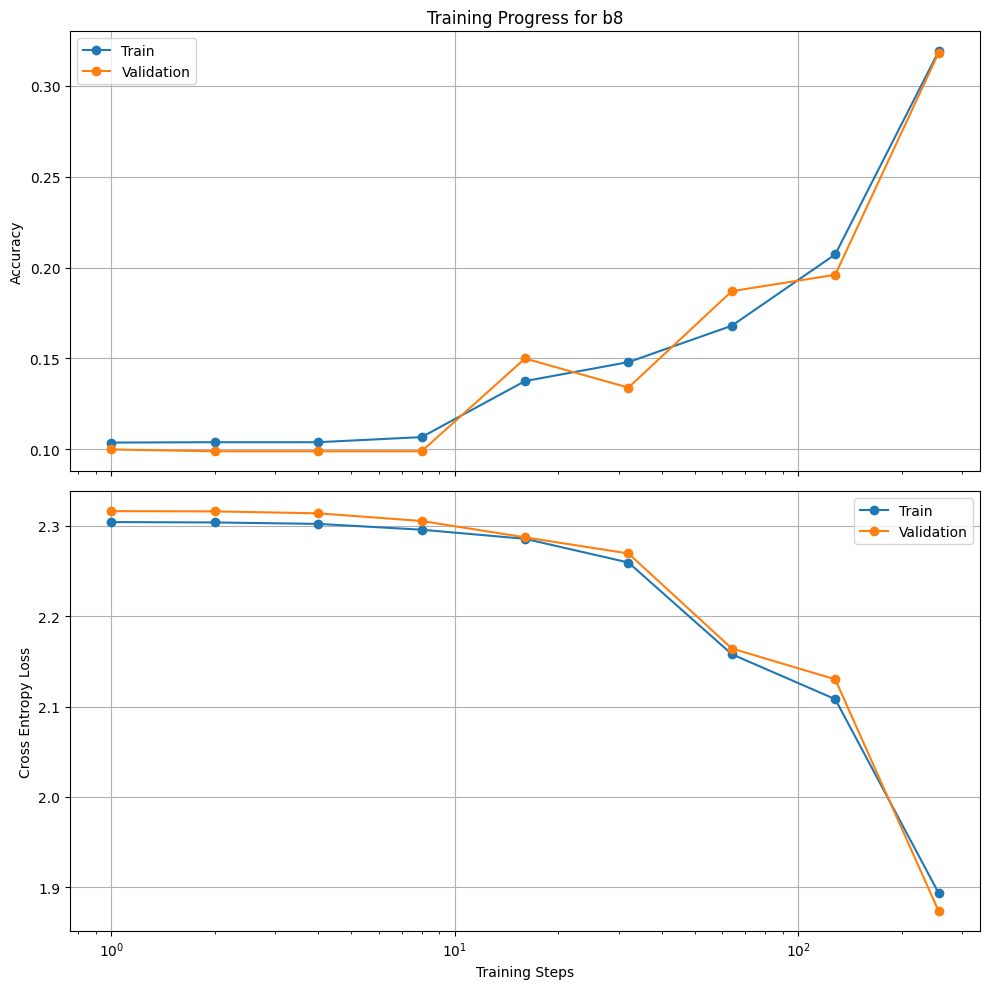

In [8]:
metrics = evaluate_checkpoints("b8")

  0%|          | 0/7 [00:00<?, ?it/s]

Step 1: Train acc: 0.104, loss: 2.304

 14%|█▍        | 1/7 [00:02<00:12,  2.11s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Train acc: 0.104, loss: 2.304

 29%|██▊       | 2/7 [00:04<00:10,  2.01s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Train acc: 0.103, loss: 2.303

 43%|████▎     | 3/7 [00:06<00:07,  1.98s/it]

, Val acc: 0.100, loss: 2.314
Step 8: Train acc: 0.104, loss: 2.297

 57%|█████▋    | 4/7 [00:07<00:05,  1.97s/it]

, Val acc: 0.101, loss: 2.306
Step 16: Train acc: 0.119, loss: 2.283

 71%|███████▏  | 5/7 [00:09<00:03,  1.98s/it]

, Val acc: 0.123, loss: 2.286
Step 32: Train acc: 0.151, loss: 2.260

 86%|████████▌ | 6/7 [00:11<00:02,  2.00s/it]

, Val acc: 0.157, loss: 2.263
Step 64: Train acc: 0.178, loss: 2.158

100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


, Val acc: 0.193, loss: 2.177


  0%|          | 0/7 [00:00<?, ?it/s]

Step 1: Train acc: 0.104, loss: 2.304

 14%|█▍        | 1/7 [00:02<00:12,  2.05s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Train acc: 0.104, loss: 2.304

 29%|██▊       | 2/7 [00:04<00:09,  1.99s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Train acc: 0.104, loss: 2.302

 43%|████▎     | 3/7 [00:06<00:08,  2.03s/it]

, Val acc: 0.099, loss: 2.314
Step 8: Train acc: 0.107, loss: 2.296

 57%|█████▋    | 4/7 [00:08<00:06,  2.02s/it]

, Val acc: 0.099, loss: 2.305
Step 16: Train acc: 0.137, loss: 2.286

 71%|███████▏  | 5/7 [00:10<00:04,  2.05s/it]

, Val acc: 0.149, loss: 2.287
Step 32: Train acc: 0.148, loss: 2.259

 86%|████████▌ | 6/7 [00:12<00:02,  2.00s/it]

, Val acc: 0.133, loss: 2.270
Step 64: Train acc: 0.168, loss: 2.157

100%|██████████| 7/7 [00:14<00:00,  2.01s/it]

, Val acc: 0.187, loss: 2.163


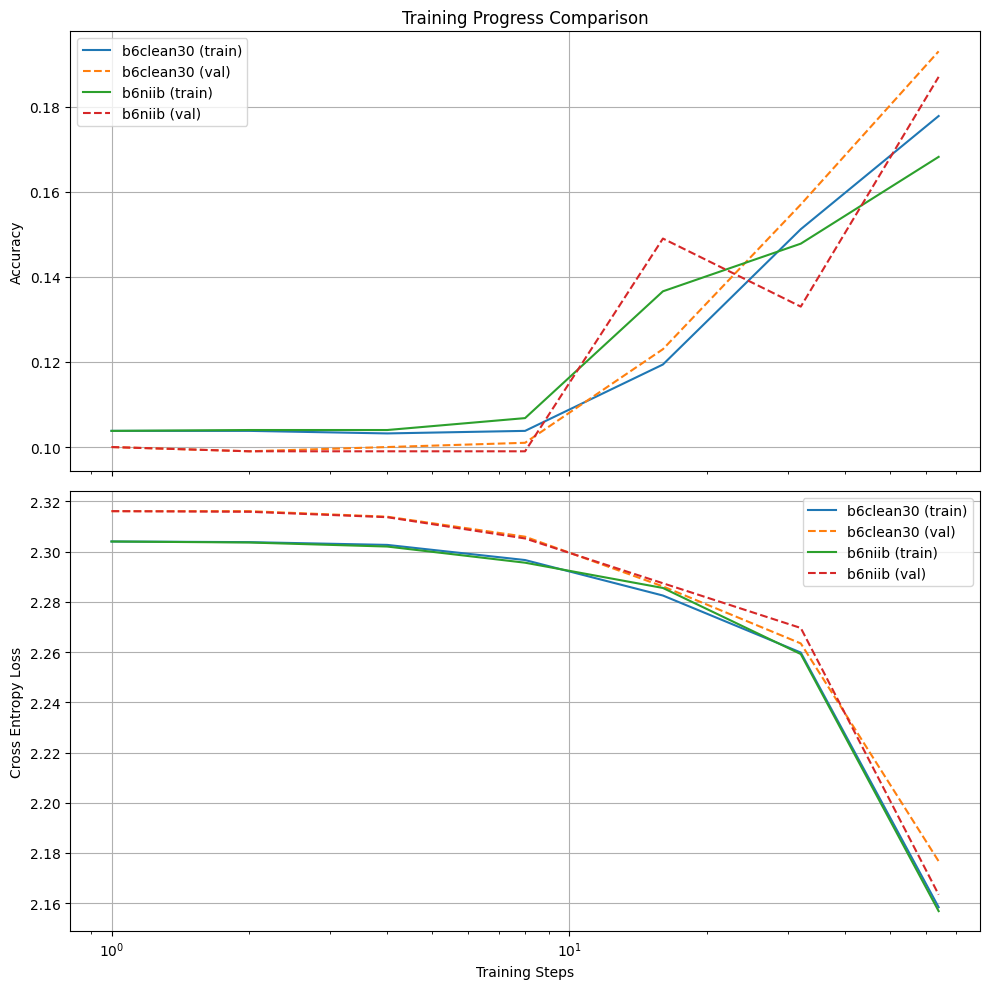

In [18]:
metrics6 = evaluate_checkpoints("runs/b6clean30", "runs/b6niib")

  0%|          | 0/7 [00:00<?, ?it/s]

Step 1: Train acc: 0.104, loss: 2.304

 14%|█▍        | 1/7 [00:01<00:11,  1.93s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Train acc: 0.104, loss: 2.304

 29%|██▊       | 2/7 [00:03<00:09,  1.91s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Train acc: 0.103, loss: 2.303

 43%|████▎     | 3/7 [00:05<00:07,  1.92s/it]

, Val acc: 0.100, loss: 2.314
Step 8: Train acc: 0.104, loss: 2.297

 57%|█████▋    | 4/7 [00:07<00:05,  1.99s/it]

, Val acc: 0.101, loss: 2.306
Step 16: Train acc: 0.119, loss: 2.283

 71%|███████▏  | 5/7 [00:09<00:03,  1.98s/it]

, Val acc: 0.123, loss: 2.286
Step 32: Train acc: 0.151, loss: 2.260

 86%|████████▌ | 6/7 [00:11<00:01,  1.96s/it]

, Val acc: 0.157, loss: 2.263
Step 64: Train acc: 0.178, loss: 2.158

100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


, Val acc: 0.193, loss: 2.177


  0%|          | 0/5 [00:00<?, ?it/s]

Step 1: Train acc: 0.104, loss: 2.304

 20%|██        | 1/5 [00:01<00:07,  1.94s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Train acc: 0.104, loss: 2.304

 40%|████      | 2/5 [00:03<00:05,  1.92s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Train acc: 0.104, loss: 2.302

 60%|██████    | 3/5 [00:05<00:03,  1.94s/it]

, Val acc: 0.099, loss: 2.314
Step 8: Train acc: 0.107, loss: 2.296

 80%|████████  | 4/5 [00:07<00:01,  1.95s/it]

, Val acc: 0.099, loss: 2.305
Step 16: Train acc: 0.137, loss: 2.286

100%|██████████| 5/5 [00:09<00:00,  1.94s/it]

, Val acc: 0.149, loss: 2.287


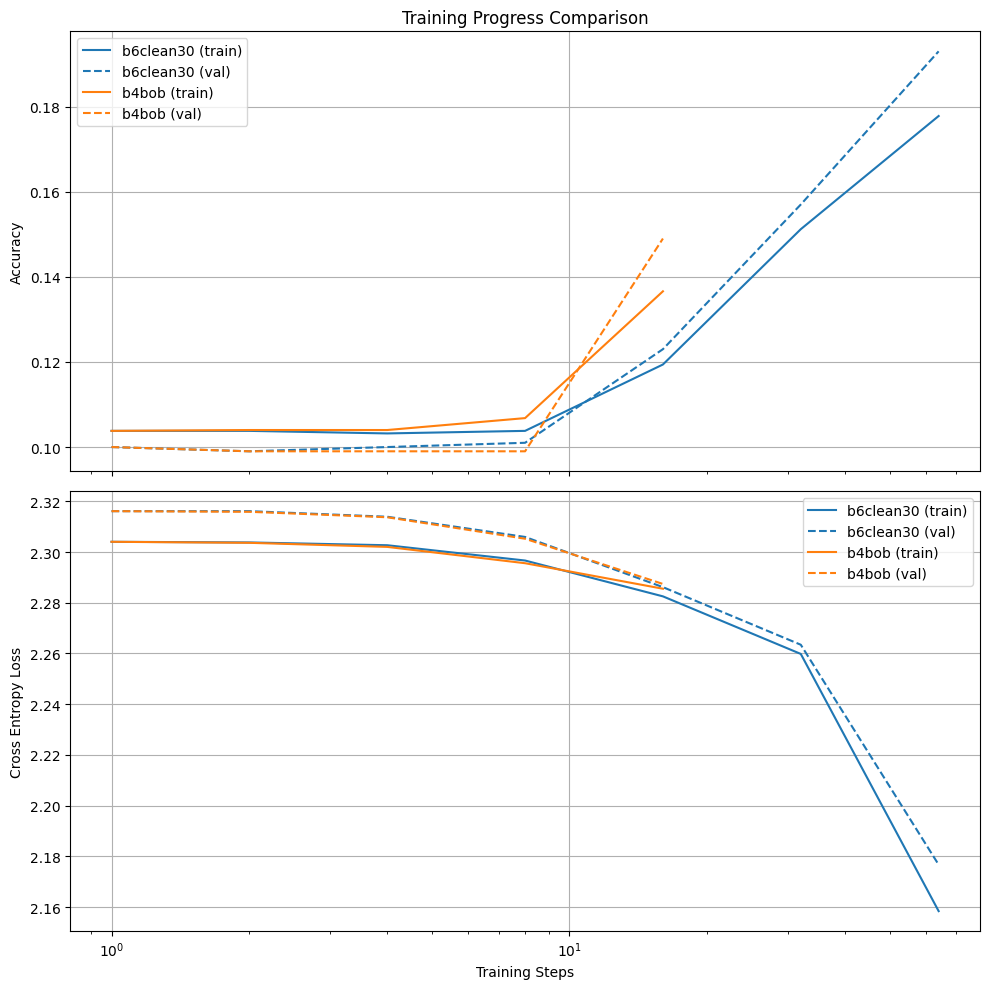

In [21]:
metrics6 = evaluate_checkpoints("runs/b6clean30", "runs/b4bob")